Here I will be showing an analysis of ImageWoof on a standard Resnet 50 vs a Resnet50 Backbone NTS-Net. All defined functions are below an available in my github repository. One bug I have not solved is total_loss needs to be defined in the notebook, I cannot store it in the .py. Each will be run for about ten epochs

In [0]:
!git clone https://github.com/muellerzr/fastai_nts_net.git

fatal: destination path 'fastai_nts_net' already exists and is not an empty directory.


## Standard Resnet 50 Pretrained

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
bs = 32 # fix to four if needed

In [0]:
path = untar_data(URLs.PETS)

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
fnames = get_image_files(path_img)

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=448, bs=12
                                  ).normalize(imagenet_stats)

In [0]:
learn = Learner(data, models.resnet50(True), loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-03
Min loss divided by 10: 6.92E-03


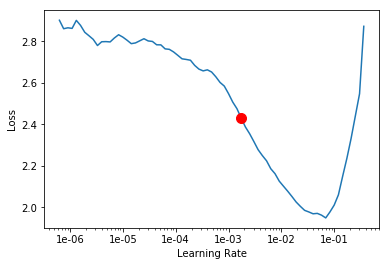

In [0]:
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(4, 1.74E-03, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,3.524024,3.731314,0.203654,04:38
1,2.906492,3.253519,0.349120,04:36
2,2.283403,2.007472,0.690122,04:35
3,1.848644,1.736027,0.784844,04:36


## NTS-Net

In [0]:
from fastai_nts_net.model import *
from fastai_nts_net.prediction import *
from fastai_nts_net.loss_functions import *

In [0]:
net = attention_net(6, data.c, 4, pretrained=True)

In [0]:
def mytotal_loss(out, label):
    
    n = LabelSmoothingCrossEntropy()
    raw_logits, concat_logits, part_logits, _, top_n_prob = out
    
    bs = len(raw_logits)
    
    lbl = label.unsqueeze(1).repeat(1, 6).view(-1)
    lgt = part_logits.view(bs * 6, -1)
    
    part_loss = list_loss(lgt, lbl).view(bs,6)
    raw_loss = n.forward(raw_logits, label)        #here
    concat_loss = n.forward(concat_logits, label)  #here
    rank_loss = ranking_loss(top_n_prob, part_loss, 6)
    partcls_loss = n.forward(lgt, lbl)             #here
    
   
    total_loss = rank_loss + raw_loss + concat_loss + partcls_loss
    return total_loss.squeeze(0)

In [0]:
learn = Learner(data, net, loss_func=mytotal_loss, metrics=metric)

In [0]:
learn.fit_one_cycle(4, 1.74E-03, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,metric,time
0,22.747169,27.543415,0.134641,11:16
1,19.866039,19.254139,0.451962,11:14
2,16.520298,15.801096,0.743572,11:12
3,15.166106,15.072411,0.826793,11:11
